## DAB304-Healthcare Project
## MIMIC-III Clinical Database 1.4
## COMBINED TABLE


**Websites:** 

https://physionet.org/content/mimiciii/1.4/

https://mimic.mit.edu/docs/iii/tables/

https://mit-lcp.github.io/mimic-schema-spy/tables/prescriptions.html

https://www.aapc.com/codes/icd9-codes-vol3-range

**Admission Table Description:**

- row_id: Unique row identifier.
- subject_id: Foreign key. Identifies the patient.
- hadm_id: Primary key. Identifies the hospital stay.
- admittime: Time of admission to the hospital.
- dischtime: Time of discharge from the hospital.
- deathtime: Time of death. Nullable.
- admission_type: Type of admission, for example, emergency or elective.
- admission_location: Admission location.
- discharge_location: Discharge location.
- insurance: Insurance type.
- language: Language. Nullable.
- religion: Religion. Nullable.
- marital_status: Marital status. Nullable.
- ethnicity: Ethnicity.
- edregtime: Time of registration in the emergency department. Nullable.
- edouttime: Time of leaving the emergency department. Nullable.
- diagnosis: Diagnosis. Nullable.
- hospital_expire_flag: Hospital admission has at least one observation in the CHARTEVENTS table. Nullable.
- has_chartevents_data: Hospital admission has at least one observation in the CHARTEVENTS table.

**Patients Table Description:**

- row_id: Unique row identifier.
- subject_id: Primary key. Identifies the patient.
- gender: Gender.
- dob: Date of birth.
- dod: Date of death. Null if the patient was alive at least 90 days post hospital discharge.
- dod_hosp: Date of death recorded in the hospital records.
- dod_ssn: Date of death recorded in the social security records.
- expire_flag: Flag indicating that the patient has died.

**Important Notes:**

- For datetime data, due to data deidentification, please refer to the following link: https://www.nature.com/articles/sdata201635

- For Patients table: DOB: Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission.

In [1]:
!pip install pycaret

In [2]:
### not filter the dead patients, put the condition when trying the model, only considering alive

In [3]:
#importing the libraries 
import pandas as pd
import numpy as np
import warnings  # Import the warnings module
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

In [4]:
# Load necessary tables from MIMIC-III dataset
# load admission dataset

admissions = pd.read_csv('admissions_clean.csv')
patients = pd.read_csv('patients_table_clean.csv')


In [5]:
#checking first rows
admissions.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,Readmitted,adm_disch_diff,disch_death_diff,erreg_erout_diff
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,0,1.144444,NaN,0.1375
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,1,5.496528,NaN,NaN


In [6]:
patients.head(2)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,1900-01-01,1900-01-01,1900-01-01,No
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,1900-01-01,Yes


In [7]:
#display the dataframe

print(f'admissions_shape:', admissions.shape)
print(f'patients_shape:', patients.shape)

admissions_shape: (58834, 23)
patients_shape: (46520, 8)


In [8]:
# Merge the admissions and patients tables
merged_df = pd.merge(admissions, patients[['SUBJECT_ID', 'GENDER', 'EXPIRE_FLAG','DOB']], 
                     how='left', on=['SUBJECT_ID'])
merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,Readmitted,adm_disch_diff,disch_death_diff,erreg_erout_diff,GENDER,EXPIRE_FLAG,DOB
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,BENZODIAZEPINE OVERDOSE,0,1,0,1.144444,NaN,0.137500,F,No,2131-05-07
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,1,5.496528,NaN,NaN,M,No,2082-07-17
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,URGENT/EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,BRAIN MASS,0,1,1,6.768056,NaN,NaN,M,No,2082-07-17
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,URGENT/EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,INTERIOR MYOCARDIAL INFARCTION,0,1,0,2.856944,NaN,NaN,M,No,2100-05-31
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,ACUTE CORONARY SYNDROME,0,1,0,3.534028,NaN,0.143056,M,No,2101-11-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58829,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,URGENT/EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,TRAUMA,0,1,0,2.742361,NaN,0.122917,F,No,2111-11-05
58830,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,URGENT/EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,SAH,1,1,0,0.548611,0.0,0.154861,F,Yes,2067-09-21
58831,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,RENAL CANCER/SDA,0,1,0,8.203472,NaN,NaN,M,No,2158-03-02
58832,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,S/P FALL,0,0,1,41.445833,NaN,0.144444,F,No,2068-02-04


In [9]:
#renaming the column 'EXPIRE_FLAG'
merged_df['EXPIRE_FLAG'] = merged_df['EXPIRE_FLAG'].replace({'No': 0, 'Yes': 1})
merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,Readmitted,adm_disch_diff,disch_death_diff,erreg_erout_diff,GENDER,EXPIRE_FLAG,DOB
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,BENZODIAZEPINE OVERDOSE,0,1,0,1.144444,NaN,0.137500,F,0,2131-05-07
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,1,5.496528,NaN,NaN,M,0,2082-07-17
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,URGENT/EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,BRAIN MASS,0,1,1,6.768056,NaN,NaN,M,0,2082-07-17
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,URGENT/EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,INTERIOR MYOCARDIAL INFARCTION,0,1,0,2.856944,NaN,NaN,M,0,2100-05-31
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,ACUTE CORONARY SYNDROME,0,1,0,3.534028,NaN,0.143056,M,0,2101-11-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58829,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,URGENT/EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,TRAUMA,0,1,0,2.742361,NaN,0.122917,F,0,2111-11-05
58830,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,URGENT/EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,SAH,1,1,0,0.548611,0.0,0.154861,F,1,2067-09-21
58831,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,RENAL CANCER/SDA,0,1,0,8.203472,NaN,NaN,M,0,2158-03-02
58832,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,S/P FALL,0,0,1,41.445833,NaN,0.144444,F,0,2068-02-04


In [10]:
merged_df['EXPIRE_FLAG'].value_counts()

EXPIRE_FLAG
0    36372
1    22462
Name: count, dtype: int64

- Updating Datatypes:

In [11]:
#to update column data type admissions table
to_datetime = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME', 'DOB']

for col in to_datetime:
    merged_df[col] = pd.to_datetime(merged_df[col])

# to update data type to admissions
to_string = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID']

for col in to_string:
    merged_df[col] = merged_df[col].astype('str')

In [12]:
# Calculate age using the difference in years
merged_df['AGE'] = (merged_df['ADMITTIME'].dt.year - merged_df['DOB'].dt.year)

merged_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,Readmitted,adm_disch_diff,disch_death_diff,erreg_erout_diff,GENDER,EXPIRE_FLAG,DOB,AGE
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,0,1,0,1.144444,NaN,0.137500,F,0,2131-05-07,65
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,0,1,1,5.496528,NaN,NaN,M,0,2082-07-17,71
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,URGENT/EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,0,1,1,6.768056,NaN,NaN,M,0,2082-07-17,75
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,URGENT/EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,0,1,0,2.856944,NaN,NaN,M,0,2100-05-31,39
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,0,1,0,3.534028,NaN,0.143056,M,0,2101-11-21,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58829,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaT,URGENT/EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,0,1,0,2.742361,NaN,0.122917,F,0,2111-11-05,20
58830,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,URGENT/EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,1,1,0,0.548611,0.0,0.154861,F,1,2067-09-21,84
58831,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,0,1,0,8.203472,NaN,NaN,M,0,2158-03-02,42
58832,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaT,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,0,0,1,41.445833,NaN,0.144444,F,0,2068-02-04,60


In [13]:

# Calculate the lOS
merged_df['DAYS_LENGHT_OF_STAY'] = (merged_df['DISCHTIME'] - merged_df['ADMITTIME']).dt.days

# Calculate the next admission date for each admission episode
merged_df['NEXT_ADMITTIME'] = merged_df.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)

# Calculate the days until next admission
merged_df['DAYS_NEXT_ADMIT'] = (merged_df['NEXT_ADMITTIME'] - merged_df['DISCHTIME']).dt.days

# Replace NaT with "No_Next_Admission"
merged_df['DIAGNOSIS'] = merged_df['DIAGNOSIS'].fillna("No Record")
merged_df['NEXT_ADMITTIME'] = merged_df['NEXT_ADMITTIME'].fillna("No_Next_Admission")
merged_df['DAYS_NEXT_ADMIT'] = merged_df['DAYS_NEXT_ADMIT'].fillna(-1.00) #-1 for there is no next admission day

# Identify realive_patients within 30 and 60 days
merged_df['READMISSION_30D'] = (merged_df['DAYS_NEXT_ADMIT'] >= 0) & (merged_df['DAYS_NEXT_ADMIT'] <= 30)
# merged_df['READMISSION_60D'] = (merged_df['DAYS_NEXT_ADMIT'] >= 0) & (merged_df['DAYS_NEXT_ADMIT'] <= 60)

# Calculate readmitted count, total unique patients, and readmission percentage 30 days
readmitted_count_30D = merged_df['READMISSION_30D'].sum()
# readmitted_count_60D = merged_df['READMISSION_60D'].sum()
total_unique_patients = merged_df['SUBJECT_ID'].nunique()
readmission_percentage_30D = (readmitted_count_30D / total_unique_patients) * 100
# readmission_percentage_60D = (readmitted_count_60D / total_unique_patients) * 100

print("Total number of unique patients:", total_unique_patients)
print("Number of patients readmitted within 30 days:", readmitted_count_30D)
# print("Number of patients readmitted within 60 days:", readmitted_count_60D)
print("Percentage of patients readmitted within 30 days: {:.2f}%".format(readmission_percentage_30D))
# print("Percentage of patients readmitted within 60 days: {:.2f}%".format(readmission_percentage_60D))


Total number of unique patients: 46413
Number of patients readmitted within 30 days: 3401
Percentage of patients readmitted within 30 days: 7.33%


In [14]:
#creating a copy of the dataframe
readmission = merged_df.copy()
readmission.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,disch_death_diff,erreg_erout_diff,GENDER,EXPIRE_FLAG,DOB,AGE,DAYS_LENGHT_OF_STAY,NEXT_ADMITTIME,DAYS_NEXT_ADMIT,READMISSION_30D
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,URGENT/EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,0.1375,F,0,2131-05-07,65,1,No_Next_Admission,-1.0,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,M,0,2082-07-17,71,5,2157-10-18 19:34:00,1501.0,False


In [15]:
# drop unnecessary columns
columns_todrop = ['DEATHTIME', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA',
                  'adm_disch_diff', 'disch_death_diff', 'erreg_erout_diff', 'DOB', 'NEXT_ADMITTIME', 'DAYS_NEXT_ADMIT','Readmitted']

readmission.drop(columns = columns_todrop, inplace = True)

In [16]:
#checking the information of the dataframe
readmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58834 entries, 0 to 58833
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ROW_ID               58834 non-null  object        
 1   SUBJECT_ID           58834 non-null  object        
 2   HADM_ID              58834 non-null  object        
 3   ADMITTIME            58834 non-null  datetime64[ns]
 4   DISCHTIME            58834 non-null  datetime64[ns]
 5   ADMISSION_TYPE       58834 non-null  object        
 6   ADMISSION_LOCATION   58834 non-null  object        
 7   DISCHARGE_LOCATION   58834 non-null  object        
 8   INSURANCE            58834 non-null  object        
 9   LANGUAGE             58834 non-null  object        
 10  RELIGION             58834 non-null  object        
 11  MARITAL_STATUS       58834 non-null  object        
 12  ETHNICITY            58834 non-null  object        
 13  DIAGNOSIS            58834 non-

In [17]:
#checking for null values
readmission.isnull().sum()

ROW_ID                 0
SUBJECT_ID             0
HADM_ID                0
ADMITTIME              0
DISCHTIME              0
ADMISSION_TYPE         0
ADMISSION_LOCATION     0
DISCHARGE_LOCATION     0
INSURANCE              0
LANGUAGE               0
RELIGION               0
MARITAL_STATUS         0
ETHNICITY              0
DIAGNOSIS              0
GENDER                 0
EXPIRE_FLAG            0
AGE                    0
DAYS_LENGHT_OF_STAY    0
READMISSION_30D        0
dtype: int64

In [18]:
# Counting the occurrences of Alive and Dead in the 'EXPIRE_FLAG' column
alive_count = readmission['EXPIRE_FLAG'].value_counts().get(0, 0)
dead_count = readmission['EXPIRE_FLAG'].value_counts().get(1, 0)

# Total number of unique patients
total_unique_patients = readmission['SUBJECT_ID'].nunique()

# Calculating the percentage of alive and dead patients
alive_percentage = (alive_count / total_unique_patients) * 100
dead_percentage = (dead_count / total_unique_patients) * 100

print("Total number of unique patients:", total_unique_patients)
print("Number of Alive Patients:", alive_count)
print("Number of Dead Patients:", dead_count)
print("Percentage of Alive Patients: {:.2f}%".format(alive_percentage))
print("Percentage of Dead Patients: {:.2f}%".format(dead_percentage))


Total number of unique patients: 46413
Number of Alive Patients: 36372
Number of Dead Patients: 22462
Percentage of Alive Patients: 78.37%
Percentage of Dead Patients: 48.40%


In [19]:
# Define age groups based on age ranges
def assign_age_group(age):
    if age <= 17:
        return 'Children (0-17)'
    elif 18 <= age <= 64:
        return 'Adults (18-64)'
    else:
        return 'Elderly (65+)'

# Apply the function to create the 'age_group' column
readmission['age_group'] = readmission['AGE'].apply(assign_age_group)

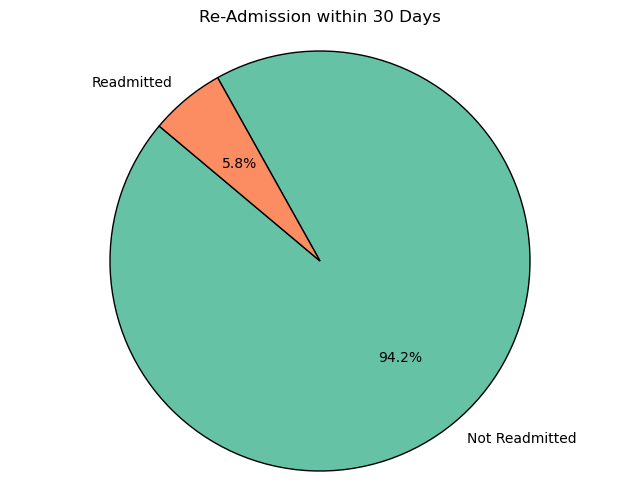

In [20]:
import matplotlib.pyplot as plt

# Calculate the percentages
percentages = readmission['READMISSION_30D'].value_counts(normalize=True) * 100

# Define custom colors
custom_colors = ['#66c2a5', '#fc8d62']

# Plotting the pie chart with custom colors and borders
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=['Not Readmitted', 'Readmitted'], autopct='%1.1f%%', colors=custom_colors, startangle=140, wedgeprops=dict(edgecolor='black'))
plt.title('Re-Admission within 30 Days')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### Visulaizations

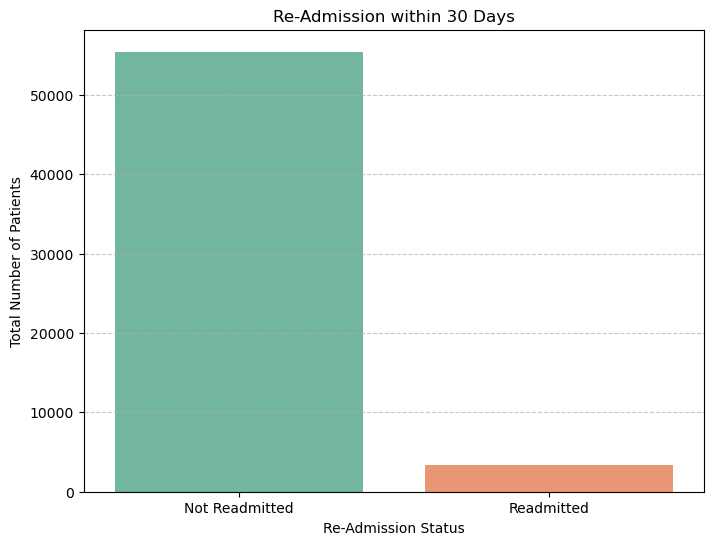

In [21]:
# Graph showing the 'Re-Admitted and Not Re-admitted within 30 days'
# Count the occurrences of each value in the 'READMISSION_30D' column
readmission_counts = readmission['READMISSION_30D'].value_counts()

# Plotting the graph
plt.figure(figsize=(8, 6))
sns.barplot(x=readmission_counts.index, y=readmission_counts.values, palette='Set2')
plt.title('Re-Admission within 30 Days')
plt.xlabel('Re-Admission Status')
plt.ylabel('Total Number of Patients')
plt.xticks(ticks=[0, 1], labels=['Not Readmitted', 'Readmitted'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


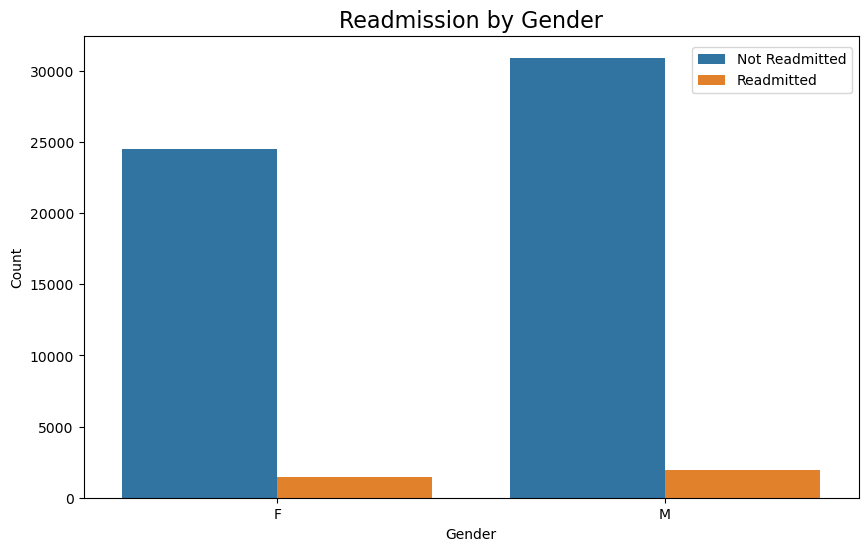

In [22]:
# Count Plot for Readmission by Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=readmission, x='GENDER', hue='READMISSION_30D')
plt.title('Readmission by Gender', fontsize=16)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(loc='upper right', labels=['Not Readmitted', 'Readmitted'], bbox_to_anchor=(1, 0.99))
plt.show()


<Figure size 1000x600 with 0 Axes>

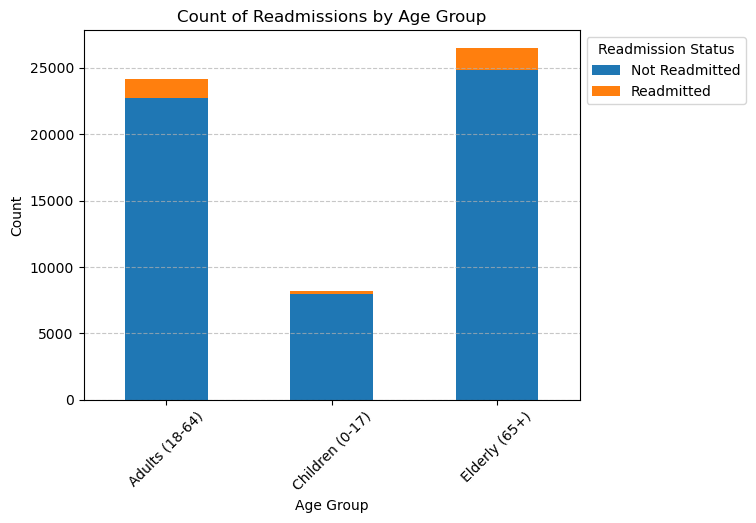

In [23]:
# Define age groups
# age_groups = ['Children (0-17)', 'Adults (18-64)', 'Elderly (65+)']
bins = [0, 18, 65, 120]  # Age bin ranges
# Count readmissions within each age group
age_readmission_counts = readmission.groupby(['age_group', 'READMISSION_30D']).size().unstack(fill_value=0)

# Plotting the graph
plt.figure(figsize=(10, 6))
age_readmission_counts.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
plt.title('Count of Readmissions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(['Not Readmitted', 'Readmitted'], title='Readmission Status', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


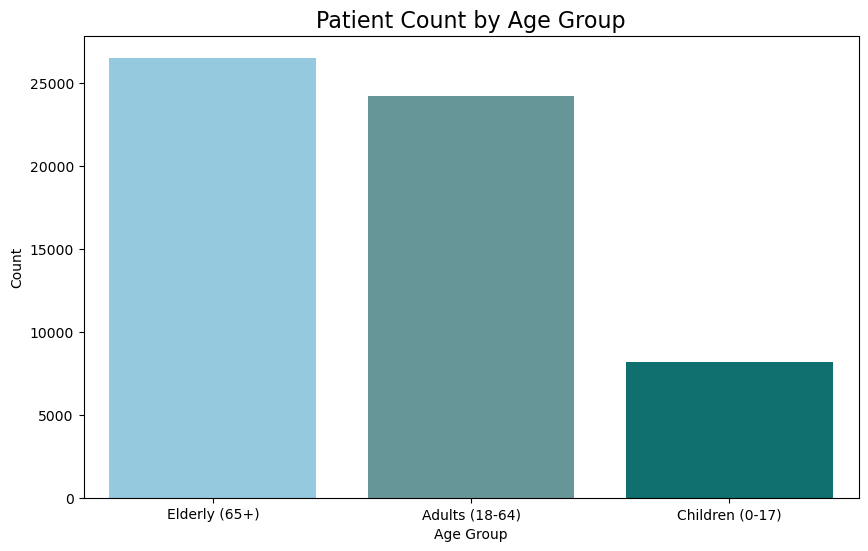

In [24]:
# Graphs to show Age Groups
# Define age groups
bins = [0, 18, 65, 120]  # Age bin ranges

# Count patients in each age group
age_group_counts = readmission['age_group'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
custom_palette = ['skyblue', 'cadetblue', 'teal']
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette=custom_palette)
plt.title('Patient Count by Age Group', fontsize=16)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()



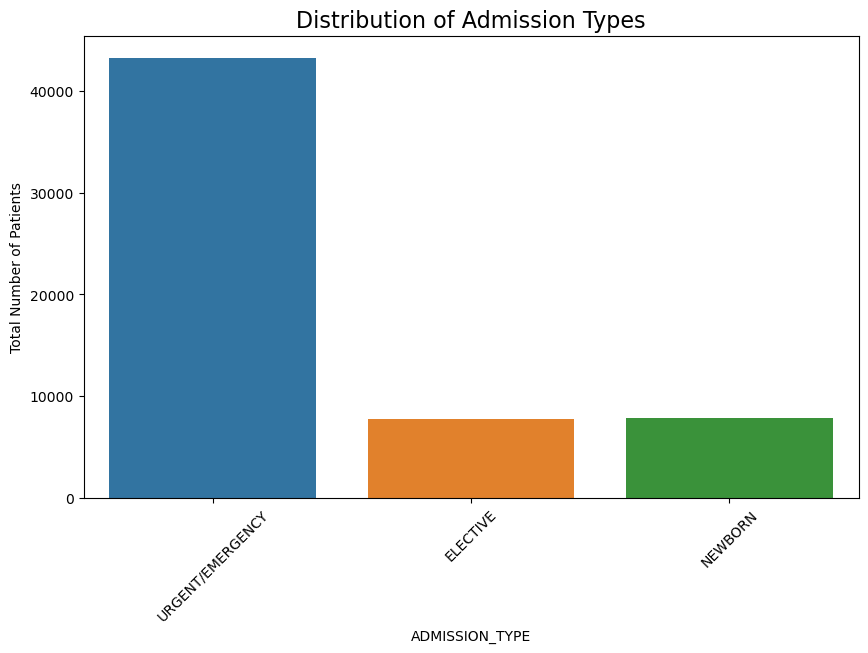

In [25]:
# Bar Plot for Admission Type
plt.figure(figsize=(10, 6))
sns.countplot(data=readmission, x='ADMISSION_TYPE')
plt.title('Distribution of Admission Types', fontsize=16)
plt.ylabel('Total Number of Patients')
plt.xticks(rotation=45)
plt.show()

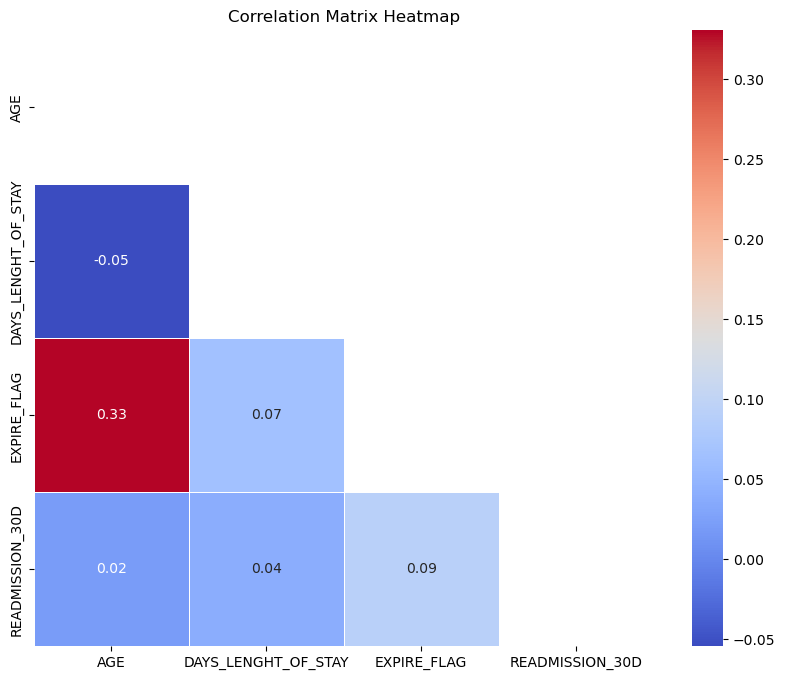

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation calculation
numerical_columns = ['AGE', 'DAYS_LENGHT_OF_STAY', 'EXPIRE_FLAG', 'READMISSION_30D']

# Calculate correlation matrix
corr_matrix = readmission[numerical_columns].corr()

# to remove the upper portion of the matrix; contains the same information
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask  = mask, annot=True, cmap='coolwarm', fmt=".2f", linewidth = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


## Identifying the best model

In [27]:
from pycaret.classification import *

# Convert the target variable to 0 and 1
readmission['READMISSION_30D'] = readmission['READMISSION_30D'].astype(int)

# Initialize the pycaret environment
clf = setup(readmission, target='READMISSION_30D', session_id=123)

,Description,Value
0,Session id,123
1,Target,READMISSION_30D
2,Target type,Binary
3,Original data shape,"(58834, 20)"
4,Transformed data shape,"(58834, 79)"
5,Transformed train set shape,"(41183, 79)"
6,Transformed test set shape,"(17651, 79)"
7,Numeric features,3
8,Date features,2
9,Categorical features,14


In [28]:
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:54:26
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2820
dt,Decision Tree Classifier,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2430
ridge,Ridge Classifier,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2640
rf,Random Forest Classifier,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4200
qda,Quadratic Discriminant Analysis,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2920
ada,Ada Boost Classifier,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2760
gbc,Gradient Boosting Classifier,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6660
lda,Linear Discriminant Analysis,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3230
et,Extra Trees Classifier,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3500
xgboost,Extreme Gradient Boosting,0.9422,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4830


Model to Run

- log
- KKN
- Decision tree
- Random Forest Clas
- Gradient Boosting Classifier

In [29]:
readmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58834 entries, 0 to 58833
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ROW_ID               58834 non-null  object        
 1   SUBJECT_ID           58834 non-null  object        
 2   HADM_ID              58834 non-null  object        
 3   ADMITTIME            58834 non-null  datetime64[ns]
 4   DISCHTIME            58834 non-null  datetime64[ns]
 5   ADMISSION_TYPE       58834 non-null  object        
 6   ADMISSION_LOCATION   58834 non-null  object        
 7   DISCHARGE_LOCATION   58834 non-null  object        
 8   INSURANCE            58834 non-null  object        
 9   LANGUAGE             58834 non-null  object        
 10  RELIGION             58834 non-null  object        
 11  MARITAL_STATUS       58834 non-null  object        
 12  ETHNICITY            58834 non-null  object        
 13  DIAGNOSIS            58834 non-

In [30]:
readmission.isnull().sum()

ROW_ID                 0
SUBJECT_ID             0
HADM_ID                0
ADMITTIME              0
DISCHTIME              0
ADMISSION_TYPE         0
ADMISSION_LOCATION     0
DISCHARGE_LOCATION     0
INSURANCE              0
LANGUAGE               0
RELIGION               0
MARITAL_STATUS         0
ETHNICITY              0
DIAGNOSIS              0
GENDER                 0
EXPIRE_FLAG            0
AGE                    0
DAYS_LENGHT_OF_STAY    0
READMISSION_30D        0
age_group              0
dtype: int64

# **Logistic Regression** #

### For Alive Patients

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Filter the DataFrame to include only patients who are alive
alive_patients = readmission[readmission['EXPIRE_FLAG'] == 0]
columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
alive_patients = alive_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = alive_patients.drop('READMISSION_30D', axis=1)
y = alive_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the logistic regression model
ALive_LR_model = LogisticRegression(random_state=42)
ALive_LR_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = ALive_LR_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = ALive_LR_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.6927835051546392

Confusion Matrix (Validation Set):
 [[3950 1644]
 [ 144   82]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.96      0.71      0.82      5594
           1       0.05      0.36      0.08       226

    accuracy                           0.69      5820
   macro avg       0.51      0.53      0.45      5820
weighted avg       0.93      0.69      0.79      5820


Test Accuracy: 0.702680412371134

Confusion Matrix (Test Set):
 [[4967 2002]
 [ 161  145]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.97      0.71      0.82      6969
           1       0.07      0.47      0.12       306

    accuracy                           0.70      7275
   macro avg       0.52      0.59      0.47      7275
weighted avg       0.93      0.70      0.79      7275



#### FOR ALL PATIENTS

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# all patients (alive and dead)
all_patients = readmission.copy()

columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
all_patients = all_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = all_patients.drop('READMISSION_30D', axis=1)
y = all_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the logistic regression model
ALL_LR_model = LogisticRegression(random_state=42)
ALL_LR_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = ALL_LR_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Subset the test data to match the features used during training
# X_test_subset = X_test.drop(['SUBJECT_ID', 'HADM_ID', 'ROW_ID'], axis=1)

# Make predictions on the test set
y_pred_test = ALL_LR_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.6659301436219938

Confusion Matrix (Validation Set):
 [[7468 3621]
 [ 310  368]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.96      0.67      0.79     11089
           1       0.09      0.54      0.16       678

    accuracy                           0.67     11767
   macro avg       0.53      0.61      0.47     11767
weighted avg       0.91      0.67      0.76     11767


Test Accuracy: 0.6709441658876519

Confusion Matrix (Test Set):
 [[7511 3555]
 [ 317  384]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     11066
           1       0.10      0.55      0.17       701

    accuracy                           0.67     11767
   macro avg       0.53      0.61      0.48     11767
weighted avg       0.91      0.67      0.76     11767



#### When we are using Logistic Regression, results indicate that the model performs moderately well in classifying instances of both classes(re-admitted and not re-admitted), with an accuracy around 70% and 67% respectivaly.

# **K Neighbors Classifier** #

#### For Alive Patients

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Filter the DataFrame to include only patients who are alive
alive_patients = readmission[readmission['EXPIRE_FLAG'] == 0]
columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
alive_patients = alive_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = alive_patients.drop('READMISSION_30D', axis=1)
y = alive_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the K Nearest Neighbors (KNN) classifier
ALIVE_knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed
ALIVE_knn_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = ALIVE_knn_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = ALIVE_knn_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.7879725085910653

Confusion Matrix (Validation Set):
 [[4512 1082]
 [ 152   74]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.97      0.81      0.88      5594
           1       0.06      0.33      0.11       226

    accuracy                           0.79      5820
   macro avg       0.52      0.57      0.49      5820
weighted avg       0.93      0.79      0.85      5820


Test Accuracy: 0.7833676975945018

Confusion Matrix (Test Set):
 [[5609 1360]
 [ 216   90]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.80      0.88      6969
           1       0.06      0.29      0.10       306

    accuracy                           0.78      7275
   macro avg       0.51      0.55      0.49      7275
weighted avg       0.93      0.78      0.84      7275



#### For All Patients

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# all patients (alive and dead)
all_patients = readmission.copy()

columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
all_patients = all_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = all_patients.drop('READMISSION_30D', axis=1)
y = all_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the K Nearest Neighbors (KNN) classifier
ALL_knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed
ALL_knn_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = ALL_knn_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = ALL_knn_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.743435030169117

Confusion Matrix (Validation Set):
 [[8517 2572]
 [ 447  231]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     11089
           1       0.08      0.34      0.13       678

    accuracy                           0.74     11767
   macro avg       0.52      0.55      0.49     11767
weighted avg       0.90      0.74      0.81     11767


Test Accuracy: 0.7441998810232004

Confusion Matrix (Test Set):
 [[8514 2552]
 [ 458  243]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     11066
           1       0.09      0.35      0.14       701

    accuracy                           0.74     11767
   macro avg       0.52      0.56      0.49     11767
weighted avg       0.90      0.74      0.81     11767



#### From running K-NN results indicate that the model performs comparetively well, with an accuracy of around 78% and 74% respectivaly. 

**Decision Tree Classifier**

#### For Alive Patients

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Filter the DataFrame to include only patients who are alive
alive_patients = readmission[readmission['EXPIRE_FLAG'] == 0]
columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
alive_patients = alive_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = alive_patients.drop('READMISSION_30D', axis=1)
y = alive_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Decision Tree Classifier
alive_dt_model = DecisionTreeClassifier(random_state=42)
alive_dt_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = alive_dt_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = alive_dt_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.9017182130584193

Confusion Matrix (Validation Set):
 [[5218  376]
 [ 196   30]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      5594
           1       0.07      0.13      0.09       226

    accuracy                           0.90      5820
   macro avg       0.52      0.53      0.52      5820
weighted avg       0.93      0.90      0.91      5820


Test Accuracy: 0.9021305841924399

Confusion Matrix (Test Set):
 [[6524  445]
 [ 267   39]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      6969
           1       0.08      0.13      0.10       306

    accuracy                           0.90      7275
   macro avg       0.52      0.53      0.52      7275
weighted avg       0.92      0.90      0.91      7275



#### Decision Tree  model achieves a relatively high accuracy of around 90%.

#### For All Patients

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# all patients (alive and dead)
all_patients = readmission.copy()

columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
all_patients = all_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = all_patients.drop('READMISSION_30D', axis=1)
y = all_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Decision Tree Classifier
ALL_dt_model = DecisionTreeClassifier(random_state=42)
ALL_dt_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = ALL_dt_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = ALL_dt_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.8777938302031104

Confusion Matrix (Validation Set):
 [[10227   862]
 [  576   102]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     11089
           1       0.11      0.15      0.12       678

    accuracy                           0.88     11767
   macro avg       0.53      0.54      0.53     11767
weighted avg       0.90      0.88      0.89     11767


Test Accuracy: 0.8746494433585451

Confusion Matrix (Test Set):
 [[10192   874]
 [  601   100]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     11066
           1       0.10      0.14      0.12       701

    accuracy                           0.87     11767
   macro avg       0.52      0.53      0.53     11767
weighted avg       0.89      0.87      0.88     11767



#### Decision Tree  model achieves a relatively high accuracy of around 88%.

**Random Forest Classifier**

#### For Alive:

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Filter the DataFrame to include only patients who are alive
alive_patients = readmission[readmission['EXPIRE_FLAG'] == 0]
columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
alive_patients = alive_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = alive_patients.drop('READMISSION_30D', axis=1)
y = alive_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Random Forest Classifier
alive_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
alive_rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = alive_rf_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = alive_rf_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.9487972508591065

Confusion Matrix (Validation Set):
 [[5511   83]
 [ 215   11]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5594
           1       0.12      0.05      0.07       226

    accuracy                           0.95      5820
   macro avg       0.54      0.52      0.52      5820
weighted avg       0.93      0.95      0.94      5820


Test Accuracy: 0.9473539518900344

Confusion Matrix (Test Set):
 [[6875   94]
 [ 289   17]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      6969
           1       0.15      0.06      0.08       306

    accuracy                           0.95      7275
   macro avg       0.56      0.52      0.53      7275
weighted avg       0.93      0.95      0.94      7275



#### For All:

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# all patients (alive and dead)
all_patients = readmission.copy()

columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
all_patients = all_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = all_patients.drop('READMISSION_30D', axis=1)
y = all_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Random Forest Classifier
all_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
all_rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = all_rf_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = all_rf_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.9343078099770544

Confusion Matrix (Validation Set):
 [[10963   126]
 [  647    31]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     11089
           1       0.20      0.05      0.07       678

    accuracy                           0.93     11767
   macro avg       0.57      0.52      0.52     11767
weighted avg       0.90      0.93      0.91     11767


Test Accuracy: 0.9303985722784057

Confusion Matrix (Test Set):
 [[10921   145]
 [  674    27]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     11066
           1       0.16      0.04      0.06       701

    accuracy                           0.93     11767
   macro avg       0.55      0.51      0.51     11767
weighted avg       0.90      0.93      0.91     11767



#### Random Forest Classifier results indicate that the model achieves a high overall accuracy, around 95% and 93% respectivaly. 

**Gradient Boosting Classifier**

#### For Alive Patients

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Filter the DataFrame to include only patients who are alive
alive_patients = readmission[readmission['EXPIRE_FLAG'] == 0]
columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
alive_patients = alive_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = alive_patients.drop('READMISSION_30D', axis=1)
y = alive_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Gradient Boosting Classifier
alive_gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
alive_gb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = alive_gb_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = alive_gb_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.9484536082474226

Confusion Matrix (Validation Set):
 [[5509   85]
 [ 215   11]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      5594
           1       0.11      0.05      0.07       226

    accuracy                           0.95      5820
   macro avg       0.54      0.52      0.52      5820
weighted avg       0.93      0.95      0.94      5820


Test Accuracy: 0.9421305841924399

Confusion Matrix (Test Set):
 [[6843  126]
 [ 295   11]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      6969
           1       0.08      0.04      0.05       306

    accuracy                           0.94      7275
   macro avg       0.52      0.51      0.51      7275
weighted avg       0.92      0.94      0.93      7275



#### For All Patients

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# all patients (alive and dead)
all_patients = readmission.copy()

columns_to_drop = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID',
                   'ADMITTIME', 'DISCHTIME']
all_patients = all_patients.drop(columns=columns_to_drop)
# Convert datetime columns to numerical features
# alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
# alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = all_patients.drop('READMISSION_30D', axis=1)
y = all_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Gradient Boosting Classifier
all_gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
all_gb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_valid = all_gb_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = all_gb_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.9286139202855443

Confusion Matrix (Validation Set):
 [[10900   189]
 [  651    27]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     11089
           1       0.12      0.04      0.06       678

    accuracy                           0.93     11767
   macro avg       0.53      0.51      0.51     11767
weighted avg       0.90      0.93      0.91     11767


Test Accuracy: 0.9296337214243222

Confusion Matrix (Test Set):
 [[10910   156]
 [  672    29]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     11066
           1       0.16      0.04      0.07       701

    accuracy                           0.93     11767
   macro avg       0.55      0.51      0.51     11767
weighted avg       0.90      0.93      0.91     11767



#### Gradient Boosting results indicate that the model achieves a high overall accuracy, around 94%

In [129]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Filter the DataFrame to include only patients who are alive
alive_patients = readmission[readmission['EXPIRE_FLAG'] == 'No']

# Convert datetime columns to numerical features
alive_patients['ADMITTIME'] = (alive_patients['ADMITTIME'] - alive_patients['ADMITTIME'].min()).dt.days
alive_patients['DISCHTIME'] = (alive_patients['DISCHTIME'] - alive_patients['DISCHTIME'].min()).dt.days

X = all_patients.drop(['SUBJECT_ID', 'HADM_ID', 'ROW_ID','READMISSION_30D', 'ADMITTIME', 'DISCHTIME'], axis=1)
y = all_patients['READMISSION_30D']

# Select categorical columns (excluding datetime columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X[categorical_cols] = ordinal_encoder.fit_transform(X[categorical_cols])

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create and train the Gradient Boosting Classifier with hyperparameter tuning
gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model from grid search
best_gb_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_gb_model.predict(X_valid)

# Evaluate the model on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
class_report_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", accuracy_valid)
print("\nConfusion Matrix (Validation Set):\n", conf_matrix_valid)
print("\nClassification Report (Validation Set):\n", class_report_valid)

# Make predictions on the test set
y_pred_test = best_gb_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print("\nTest Accuracy:", accuracy_test)
print("\nConfusion Matrix (Test Set):\n", conf_matrix_test)
print("\nClassification Report (Test Set):\n", class_report_test)


Validation Accuracy: 0.9309292335518878

Confusion Matrix (Validation Set):
 [[8220  110]
 [ 501   15]]

Classification Report (Validation Set):
               precision    recall  f1-score   support

       False       0.94      0.99      0.96      8330
        True       0.12      0.03      0.05       516

    accuracy                           0.93      8846
   macro avg       0.53      0.51      0.51      8846
weighted avg       0.89      0.93      0.91      8846


Test Accuracy: 0.9337628574658077

Confusion Matrix (Test Set):
 [[8237   91]
 [ 495   24]]

Classification Report (Test Set):
               precision    recall  f1-score   support

       False       0.94      0.99      0.97      8328
        True       0.21      0.05      0.08       519

    accuracy                           0.93      8847
   macro avg       0.58      0.52      0.52      8847
weighted avg       0.90      0.93      0.91      8847



#### Gradient Boosting results indicate that the model achieves a high overall accuracy, around 93%